In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(train_img,train_labels),(_,_) = tf.keras.datasets.mnist.load_data()

In [3]:
train_img =tf.cast(train_img,tf.float32)
train_img =train_img/127.5-1
train_img =np.expand_dims(train_img,-1)

In [4]:
dataset=tf.data.Dataset.from_tensor_slices((train_img,train_labels))

In [5]:
AUTOTUNE=tf.data.AUTOTUNE

In [6]:
dataset=dataset.shuffle(60000).batch(100).prefetch(AUTOTUNE)

In [7]:
noise_dim = 50

In [8]:
def generator():
    label = tf.keras.layers.Input(shape=(()))
    seed = tf.keras.layers.Input(shape=((noise_dim)))
    
    x = tf.keras.layers.Embedding(10,50,input_length=1)(label)
    x = tf.keras.layers.concatenate([seed,x])
    
    x = tf.keras.layers.Dense(3*3*128, use_bias=False)(x)
    x=  tf.keras.layers.Reshape((3,3,128))(x)
    
    x= tf.keras.layers.Conv2DTranspose(64,3,strides=2,use_bias=False)(x)                 #7*7*64
    x= tf.keras.layers.BatchNormalization()(x)
    x= tf.keras.layers.ReLU()(x)
    
    x= tf.keras.layers.Conv2DTranspose(32,3,strides=2,padding='same',use_bias=False)(x)  #14*14*32
    x= tf.keras.layers.BatchNormalization()(x)
    x= tf.keras.layers.ReLU()(x)                                  
    
    x= tf.keras.layers.Conv2DTranspose(1,3,strides=2,padding='same',use_bias=False)(x)   #28*28*1
    output=tf.keras.layers.Activation('tanh')(x)
    
    model=tf.keras.Model(inputs=[label,seed],outputs=output)
    return model
 

In [9]:
gen= generator()

In [10]:
gen.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50)           500         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 100)          0           input_2[0][0]                    
                                                                 embedding[0][0]              

In [11]:
def discriminator():
    label = tf.keras.layers.Input(shape=(()))
    img = tf.keras.layers.Input(shape=(28,28,1))
    
    x = tf.keras.layers.Embedding(10,28*28,input_length=1)(label)
    x = tf.keras.layers.Reshape((28,28,1))(x)
    x = tf.keras.layers.concatenate([img,x])
    
    x = tf.keras.layers.Conv2D(32,3,strides=2,padding='same',use_bias=False)(x)    #14*14*32
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Conv2D(64,3,strides=2,padding='same',use_bias=False)(x)    #7*7*64
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)    
    
    x = tf.keras.layers.Conv2D(128,3,strides=2,use_bias=False)(x)                   #3*3*128
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)   
    
    x = tf.keras.layers.Flatten()(x)
    output = tf.keras.layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs=[label,img],outputs=output)
    return model

In [12]:
disc =discriminator()

In [13]:
def loss_fn(true_out,fake_out):
    true_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(true_out),true_out,from_logits=True)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_out),fake_out,from_logits=True)
    disc_loss=true_loss+fake_loss
    
    gen_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_out),fake_out,from_logits=True)
    return disc_loss,gen_loss
    

In [14]:
opt_gen=tf.keras.optimizers.Adam(learning_rate=0.0001)
opt_disc=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [15]:
@tf.function()
def train_step(image,label):
    seed=np.random.normal(size=(label.shape[0],noise_dim))
 
    
    with tf.GradientTape() as disc_t, tf.GradientTape() as gen_t:
        fake_img=gen((label,seed))
        true_out=disc((label,image))
        fake_out=disc((label,fake_img))
        disc_loss,gen_loss=loss_fn(true_out,fake_out)
        d_grad = disc_t.gradient(disc_loss,disc.trainable_variables)
        g_grad = gen_t.gradient(gen_loss,gen.trainable_variables)
        opt_disc.apply_gradients(zip(d_grad,disc.trainable_variables))
        opt_gen.apply_gradients(zip(g_grad,gen.trainable_variables))
    
        
    
    

In [16]:
epochs = 100

In [17]:
label_plot = np.array([0,1,2,3,4,5,6,7,8,9])
label_plot

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [18]:
def plot_img():
    plt.figure(figsize=(10,10))
    seed_plot= np.random.normal(size=(10,noise_dim))
    imgs =gen([label_plot,seed_plot])
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(imgs[i])
        plt.axis('off')
    plt.show()

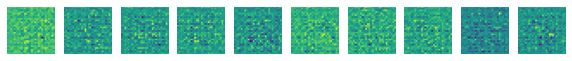

In [19]:
plot_img()

1,

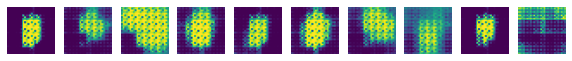

2,3,4,5,6,7,8,9,10,11,

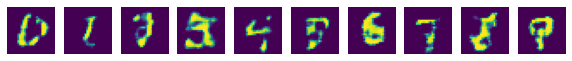

12,13,14,15,16,17,18,19,20,21,

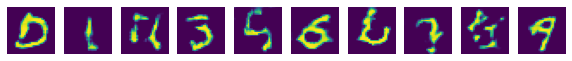

22,23,24,25,26,27,28,29,30,31,

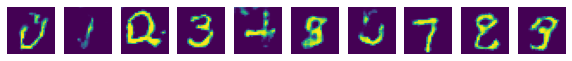

32,33,34,35,36,37,38,39,40,41,

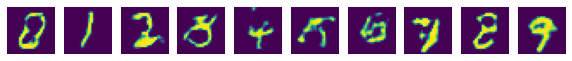

42,43,44,45,46,47,48,49,50,51,

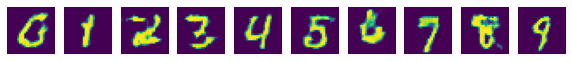

52,53,54,55,56,57,58,59,60,61,

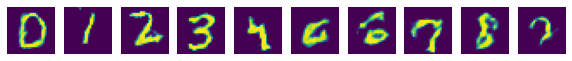

62,63,64,65,66,67,68,69,70,71,

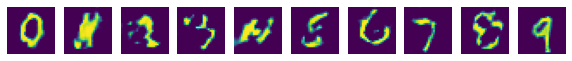

72,73,74,75,76,77,78,79,80,81,

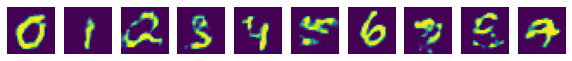

82,83,84,85,86,87,88,89,90,91,

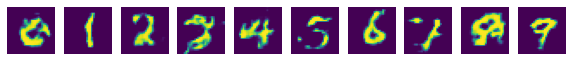

92,93,94,95,96,97,98,99,100,

In [20]:
for epoch in range(epochs):
    for image_batch,label_batch in dataset:
        train_step(image_batch,label_batch)
    print(epoch+1,end=',')
    if epoch%10==0:
        plot_img()
    

In [21]:
gen.save('gen.h5')
disc.save('disc.h5')